# Project 3 Codebook

## Topic: Spatial Analysis of Exposure to Respiratory Hazards and School Performance in Riverside, California.

#### Data and Time Frame for Analysis
1. [EJScreen data - 2020](https://open.quiltdata.com/b/spatial-ucr/tree/epa/ejscreen/)
2. [NCES/Districts - 2018/2019](https://open.quiltdata.com/b/spatial-ucr/tree/nces/schools/)
3. [ACS- 2018](https://open.quiltdata.com/b/spatial-ucr/tree/census/acs/)
4. [SEDA- Standardized test scores administered in 3rd through 8 th grade in mathematics and Reading Language Arts (RLA) over the 2008-09 through 2017-18 school years](https://edopportunity.org/)

#### TASKS
- Import software
- Retrieve Data from all four data sources.
- Create GeoDataframes for EPA EJScreen and SEDA using ACS and NCES geometry.
- Subset data for Riverside specific EJScreen respiratory hazards index and schooling outcomes for the Riverside Unified School District using SEDA. 
- Overlay RUSD schooling outcomes and EJ Respiratory Hazards Index.


### 1: Download software 

In [1]:
# Import software

import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt 
import contextily as ctx
import numpy as np
import quilt3
from geopandas_view import view 
import libpysal as lps
import seaborn as sns
import tobler as tob
plt.rcParams['figure.figsize'] = [20, 10]


###  2: Retrieve and Adjust Data

#### 2.1 Environmental Justice Screen Data From EPA

In [2]:
# Retrieve EPA EJ Screen data from UCR CGS Quilt Bucket

b = quilt3.Bucket("s3://spatial-ucr")
b.fetch("epa/ejscreen/ejscreen_2020.parquet", "./ejscreen_2020.parquet"), # Might be a good idea to get 2018
ej = pd.read_parquet('ejscreen_2020.parquet')
ej.head()

100%|██████████| 146M/146M [00:07<00:00, 20.4MB/s] 


,OBJECTID,ID,ACSTOTPOP,ACSIPOVBAS,ACSEDUCBAS,ACSTOTHH,ACSTOTHU,MINORPOP,MINORPCT,LOWINCOME,...,T_OZONE,T_OZONE_D2,T_PM25,T_PM25_D2,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,Shape_Length,Shape_Area
0,1,010010201001,636,636,418,294,294,104,0.163522,245,...,36.8 ppb (15%ile),54%ile,9.69 ug/m3 (86%ile),52%ile,4259428.0,28435.0,0,0,13443.155206,6.040790e+06
1,2,010010201002,1287,1287,885,471,485,278,0.216006,210,...,36.8 ppb (15%ile),36%ile,9.69 ug/m3 (86%ile),28%ile,5558385.0,0.0,0,0,11917.089598,7.834160e+06
2,3,010010202001,810,802,568,322,370,548,0.676543,402,...,36.8 ppb (16%ile),70%ile,9.71 ug/m3 (86%ile),72%ile,2058380.0,0.0,0,0,7770.915121,2.900774e+06
3,4,010010202002,1218,1016,875,397,482,670,0.550082,400,...,36.8 ppb (16%ile),67%ile,9.71 ug/m3 (86%ile),69%ile,1267299.0,5669.0,0,0,6506.804784,1.793332e+06
4,5,010010203001,2641,2641,1849,948,1049,899,0.340401,814,...,36.9 ppb (16%ile),51%ile,9.75 ug/m3 (86%ile),48%ile,3866515.0,9054.0,0,0,11070.367848,5.461602e+06


In [3]:
# Rename EJ column to state GEOID
ej.rename(columns = {'ID' : 'GEOID'}, inplace = True)
# ej.head()

In [4]:
ej.columns

Index(['OBJECTID', 'GEOID', 'ACSTOTPOP', 'ACSIPOVBAS', 'ACSEDUCBAS',
       'ACSTOTHH', 'ACSTOTHU', 'MINORPOP', 'MINORPCT', 'LOWINCOME',
       ...
       'T_OZONE', 'T_OZONE_D2', 'T_PM25', 'T_PM25_D2', 'AREALAND', 'AREAWATER',
       'NPL_CNT', 'TSDF_CNT', 'Shape_Length', 'Shape_Area'],
      dtype='object', length=141)

In [5]:
type(ej)

pandas.core.frame.DataFrame

Note: EPA EJ Screen is not a geodataframe so we need ACS census blockgroup data to convert it into geodataframe.

In [6]:
# Download USA Census block groups from the 2018 ACS via Quilt
geoms = gpd.read_parquet('s3://spatial-ucr/census/acs/acs_2018_bg.parquet')
geoms.head()

,n_persons_under_18,n_persons_over_60,n_persons_over_75,n_persons_over_15,n_married,n_widowed_divorced,n_total_families,n_female_headed_families,n_nonhisp_white_persons,n_nonhisp_black_persons,...,p_female_headed_families,p_nonhisp_white_persons,p_nonhisp_black_persons,p_hispanic_persons,p_native_persons,p_asian_persons,p_hawaiian_persons,p_asian_indian_persons,p_veterans,geometry
GEOID,,,,,,,,,,,,,,,,,,,,,
020130001003,287.0,213.0,26.0,1164.0,154.0,218.0,280.0,29.0,234.0,4.0,...,10.357143,16.846652,0.287977,6.839453,41.324694,23.182145,1.007919,23.182145,4.463643,"MULTIPOLYGON (((-159.91033 54.81417, -159.9057..."
020160001001,175.0,157.0,25.0,807.0,64.0,146.0,127.0,10.0,203.0,41.0,...,7.874016,20.949432,4.231166,11.764706,48.710010,9.907121,3.405573,9.907121,12.074303,"MULTIPOLYGON (((179.38874 51.94192, 179.40456 ..."
020160002001,320.0,224.0,21.0,1884.0,256.0,302.0,248.0,3.0,270.0,91.0,...,1.209677,12.517385,4.218822,12.888271,1.205378,66.759388,0.834492,66.759388,2.781641,"MULTIPOLYGON (((-167.24289 53.85467, -167.2370..."
020160002002,468.0,335.0,29.0,2220.0,304.0,435.0,341.0,6.0,916.0,114.0,...,1.759531,34.908537,4.344512,15.472561,5.182927,33.574695,3.696646,33.574695,3.620427,"MULTIPOLYGON (((-167.90386 53.22286, -167.8910..."
020200001011,75.0,79.0,37.0,404.0,49.0,73.0,63.0,0.0,351.0,4.0,...,0.000000,75.646552,0.862069,0.000000,12.715517,3.232759,0.000000,3.232759,9.482759,"MULTIPOLYGON (((-149.47075 61.45923, -149.4505..."


In [7]:
# Merge EJ and ACS data
ej_new = geoms.merge(ej, on='GEOID')
ej_new.head()

,GEOID,n_persons_under_18,n_persons_over_60,n_persons_over_75,n_persons_over_15,n_married,n_widowed_divorced,n_total_families,n_female_headed_families,n_nonhisp_white_persons,...,T_OZONE,T_OZONE_D2,T_PM25,T_PM25_D2,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,Shape_Length,Shape_Area
0,020130001003,287.0,213.0,26.0,1164.0,154.0,218.0,280.0,29.0,234.0,...,None,None,None,None,1.178921e+09,4.114837e+09,0,0,1.026354e+06,1.615713e+10
1,020160001001,175.0,157.0,25.0,807.0,64.0,146.0,127.0,10.0,203.0,...,None,None,None,None,8.552028e+09,2.208385e+10,1,2,4.442060e+06,6.008803e+10
2,020160002001,320.0,224.0,21.0,1884.0,256.0,302.0,248.0,3.0,270.0,...,None,None,None,None,7.752357e+08,6.422767e+08,0,0,2.614006e+05,4.075118e+09
3,020160002002,468.0,335.0,29.0,2220.0,304.0,435.0,341.0,6.0,916.0,...,None,None,None,None,2.048247e+09,2.459880e+09,0,1,6.481758e+05,1.276803e+10
4,020200001011,75.0,79.0,37.0,404.0,49.0,73.0,63.0,0.0,351.0,...,None,None,None,None,5.402439e+07,1.640616e+07,0,0,1.053080e+05,3.072696e+08


In [8]:
#Command to converting ej_new to geodataframe
ej_new= gpd.GeoDataFrame(ej_new)
type(ej_new)

geopandas.geodataframe.GeoDataFrame

In [9]:
# Filter EJ Screen data so it only displays CA 
ca_ej = ej_new[ej_new.GEOID.str.startswith('06')]
ca_ej.head()

,GEOID,n_persons_under_18,n_persons_over_60,n_persons_over_75,n_persons_over_15,n_married,n_widowed_divorced,n_total_families,n_female_headed_families,n_nonhisp_white_persons,...,T_OZONE,T_OZONE_D2,T_PM25,T_PM25_D2,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,Shape_Length,Shape_Area
10297,060190045062,153.0,778.0,334.0,1567.0,313.0,447.0,389.0,0.0,1293.0,...,63 ppb (98%ile),19%ile,13.9 ug/m3 (99%ile),15%ile,1285301.0,0.0,0,1,6016.799236,2.009254e+06
10298,060190046011,365.0,630.0,233.0,1475.0,253.0,472.0,437.0,17.0,881.0,...,62.7 ppb (98%ile),64%ile,14 ug/m3 (99%ile),65%ile,1176829.0,0.0,0,1,8153.747224,1.839061e+06
10299,060190046012,377.0,428.0,141.0,1139.0,246.0,255.0,294.0,0.0,914.0,...,62.7 ppb (98%ile),41%ile,14 ug/m3 (99%ile),38%ile,639720.0,0.0,0,0,4000.409939,9.997658e+05
10300,060190046021,75.0,298.0,77.0,591.0,196.0,105.0,208.0,0.0,508.0,...,63 ppb (98%ile),32%ile,14.1 ug/m3 (99%ile),28%ile,808740.0,0.0,0,0,4523.951503,1.263881e+06
10301,060190046022,282.0,156.0,42.0,859.0,272.0,112.0,276.0,0.0,610.0,...,63 ppb (98%ile),43%ile,14.1 ug/m3 (99%ile),40%ile,1126026.0,0.0,0,0,6011.567284,1.759425e+06


In [10]:
# Filter out EJ Index for Air toxics respiratory hazard index
D_RESP_2 = ca_ej.D_RESP_2 
ca_ej.D_RESP_2 = D_RESP_2.replace(to_replace= "None", value=np.nan).astype(float)

/opt/tljh/user/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [11]:
# Create variable for Riverside LA County using the fips code

riv_ej = ca_ej[ca_ej.GEOID.str.startswith("06065")] # Riverside County EJSCREEN

In [12]:
# Checking Data for Orange County
#riv_ej.head()
riv_ej.shape

(1030, 177)

In [13]:
# New dataframe for respiratory hazards index, percentage white, black and hispanic, median income
riverside_racial= riv_ej[['D_RESP_2','p_nonhisp_white_persons','p_nonhisp_black_persons','p_hispanic_persons','median_household_income','geometry']]

In [14]:
#Statistics
riverside_racial.describe()

,D_RESP_2,p_nonhisp_white_persons,p_nonhisp_black_persons,p_hispanic_persons,median_household_income
count,1030.000000,1029.000000,1029.000000,1029.000000,1011.000000
mean,161.217384,38.714570,5.436953,47.208351,68202.359050
std,239.451824,23.674844,6.572956,24.496586,30014.351265
min,-397.647715,0.000000,0.000000,0.000000,2499.000000
25%,-10.833675,19.258769,0.835322,28.214129,45834.000000
50%,113.540281,36.868687,3.112648,45.116279,63669.000000
75%,296.013932,54.930796,7.786053,64.793871,86205.500000
max,1909.488471,100.000000,62.500000,100.000000,250001.000000


### 3: Merge District Data w/ EJ Data

In [15]:
# Upload school districts data

districts = gpd.read_parquet('s3://spatial-ucr/nces/districts/school_districts_1819.parquet')

In [16]:
# Subset of the california schools from the US data
CA_dist = districts[districts.STATEFP == "06"]
#CA_dist.head()

In [17]:
# Locate Riverside Unified School District (RUSD)- better to make sure its in California

rusd_CA = districts[districts['STATEFP'].str.lower().str.contains('06')]
rusd = rusd_CA[rusd_CA['NAME'].str.lower().str.contains('riverside unified')]
rusd.head()


,STATEFP,ELSDLEA,SCSDLEA,UNSDLEA,GEOID,NAME,LSAD,LOGRADE,HIGRADE,MTFCC,SDTYP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,GEO_YEAR,SCHOOLYEAR,geometry
1598,06,None,None,33150,0633150,Riverside Unified School District,00,KG,12,G5420,None,E,231195333.0,6617991.0,+33.9233125,-117.3778383,2019,2018-2019,"POLYGON ((-117.27942 34.00459, -117.27923 33.9..."


In [18]:
# Now, let's overlay the EPA EJ data (that was combined with ACS data) on top of the RUSD shape

rusd_ej = gpd.overlay(riv_ej,rusd, how='intersection')


#### Subset data for Racial, Income and Respiratory Hazards Index for RUSD

In [19]:
# Subset of racial and income variables within RUSD
rusd_racial= rusd_ej[['D_RESP_2','n_nonhisp_white_persons','n_nonhisp_black_persons','n_hispanic_persons','p_nonhisp_white_persons','p_nonhisp_black_persons','p_hispanic_persons','median_household_income','geometry']]
# rusd_racial.head()

### 4: Combine School Locations with School District/EJ Map

In [20]:
# Download NCES school location data 
schools = gpd.read_parquet("s3://spatial-ucr/nces/schools/schools_1819.parquet")
#schools.head()

In [21]:
# Download SEDA learning outcomes data
seda = pd.read_csv("https://stacks.stanford.edu/file/druid:db586ns4974/seda_school_pool_gcs_4.0.csv",converters={"sedasch":str})
seda.sedasch=seda.sedasch.str.rjust(12, "0")
#seda.head()

In [22]:
# Convert NCES data into a GeoDataFrame
school_geoms = schools[['NCESSCH','CNTY','NMCNTY', 'geometry']]
school_geoms.head()

,NCESSCH,CNTY,NMCNTY,geometry
0,010000500870,01095,Marshall County,POINT (-86.20617 34.26019)
1,010000500871,01095,Marshall County,POINT (-86.20488 34.26223)
2,010000500879,01095,Marshall County,POINT (-86.22014 34.27332)
3,010000500889,01095,Marshall County,POINT (-86.22181 34.25270)
4,010000501616,01095,Marshall County,POINT (-86.19329 34.28985)


In [23]:
# Merge SEDA and NCES data
seda_merge = seda.merge(school_geoms, left_on="sedasch", right_on= "NCESSCH")
#seda_merge.head()

In [24]:
# Convert merged NCES/SEDA data into a GeoDataFrame and plot it
seda_merge= gpd.GeoDataFrame(seda_merge)
#seda_merge.plot()

In [25]:
# Subset data to only locate schools in Riverside County 
riv_schools = seda_merge[seda_merge['CNTY']=='06065']
#riv_schools.plot()

In [26]:
# Subset school data to find schools in RUSD

rusd_schools = gpd.overlay(riv_schools, rusd, how='intersection')

### 5: Voronoi Polygons For School Performance and Respiratory Health Index

In [27]:
# Subset of rusd schools with only mean scores
rusd_pts= rusd_schools[['gcs_mn_avg_ol','geometry']]
rusd_pts.head()

,gcs_mn_avg_ol,geometry
0,8.098470,POINT (-117.30967 33.88970)
1,4.939048,POINT (-117.30644 33.88844)
2,3.253884,POINT (-117.43514 33.94446)
3,3.960433,POINT (-117.36408 33.95469)
4,3.599937,POINT (-117.37885 33.98955)


In [28]:
# rusd_pts.plot(column='gcs_mn_avg_ol', legend=True)

In [29]:
# Subset for EJ screen for RUSD only containing Respiratory index and geometry

EJ_RUSD= rusd_ej[['D_RESP_2','geometry']]
#EJ_RUSD.plot(column='D_RESP_2', cmap='Greens', scheme='Quantiles', k=3,edgecolor='grey',
        #legend=True)

### 5.1 Overlays - Two Approaches 

#### 5.1a Approach 1 Spatial Join

<AxesSubplot:>

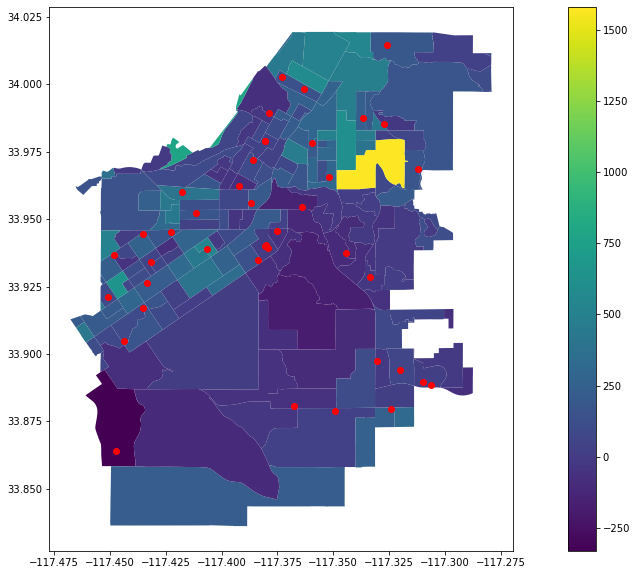

In [30]:
# 1 for 1 mapping
base  = EJ_RUSD.plot(column='D_RESP_2', legend=True)
rusd_pts.plot(color='red', ax=base)

In [31]:
rusd_sch= gpd.sjoin(rusd_pts, EJ_RUSD, how='left', op='within')
rusd_sch.head()

,gcs_mn_avg_ol,geometry,index_right,D_RESP_2
0,8.098470,POINT (-117.30967 33.88970),135,23.698113
1,4.939048,POINT (-117.30644 33.88844),135,23.698113
2,3.253884,POINT (-117.43514 33.94446),85,261.324237
3,3.960433,POINT (-117.36408 33.95469),36,-142.849901
4,3.599937,POINT (-117.37885 33.98955),6,-62.781118


In [32]:
rusd_pts['D_RESP_2a'] = rusd_sch.D_RESP_2
rusd_pts.head()

/opt/tljh/user/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,gcs_mn_avg_ol,geometry,D_RESP_2a
0,8.098470,POINT (-117.30967 33.88970),23.698113
1,4.939048,POINT (-117.30644 33.88844),23.698113
2,3.253884,POINT (-117.43514 33.94446),261.324237
3,3.960433,POINT (-117.36408 33.95469),-142.849901
4,3.599937,POINT (-117.37885 33.98955),-62.781118


In [33]:
# rusd_pts.crs

#### 5.1b. Approach 2 Areal Interpolation

In [34]:
x = rusd_pts.geometry.x
y = rusd_pts.geometry.y
cents = np.array([x,y]).T
# cents

In [35]:
schools_polygons, school_cents = lps.cg.voronoi_frames(cents)
# Schools_vd has polygons geometry
# school_cents has points geometry

In [36]:
school_cents.head()


,geometry
0,POINT (-117.30967 33.88970)
1,POINT (-117.30644 33.88844)
2,POINT (-117.43514 33.94446)
3,POINT (-117.36408 33.95469)
4,POINT (-117.37885 33.98955)


<AxesSubplot:>

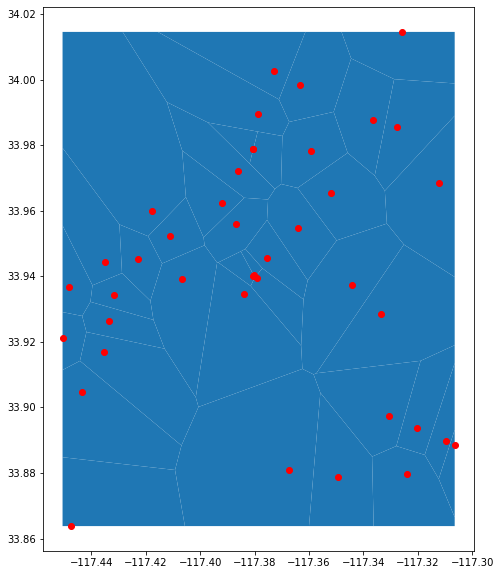

In [37]:
base = schools_polygons.plot()
rusd_pts.plot(ax=base, color='red')

In [38]:
# EJ_RUSD.crs

<AxesSubplot:>

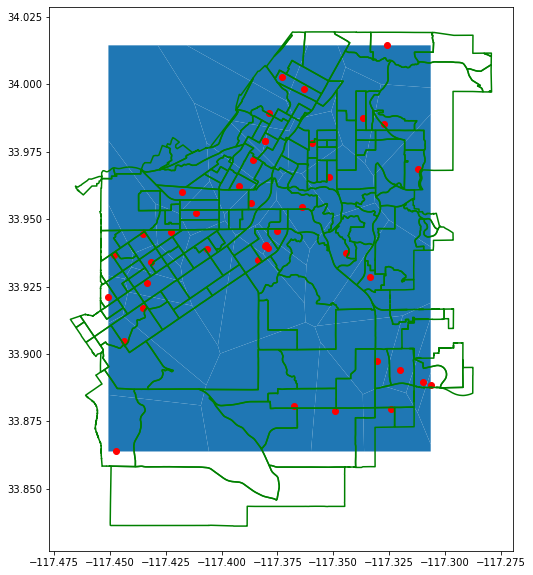

In [39]:
base = EJ_RUSD.geometry.boundary.plot(edgecolor='green')
schools_polygons.plot(ax=base)
rusd_pts.plot(ax=base, color='red')

In [40]:
schools_polygons, school_cents = lps.cg.voronoi_frames(cents, clip = EJ_RUSD.unary_union)

In [41]:
#schools_polygons.to_crs?

In [42]:
# School_Polygons had no crs here we are setting it equal to EJ_RUSD
schools_polygons.crs = EJ_RUSD.crs

In [43]:
# We need to set a crs for all the datasets
schools_polygons = schools_polygons.to_crs("EPSG:3395")
EJ_RUSD = EJ_RUSD.to_crs("EPSG:3395")
rusd_pts = rusd_pts.to_crs("EPSG:3395")

<AxesSubplot:>

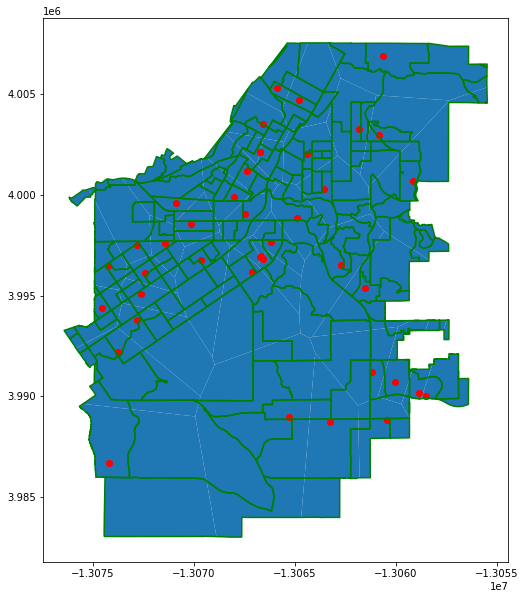

In [44]:
base = EJ_RUSD.geometry.boundary.plot(edgecolor='green')
schools_polygons.plot(ax=base)
rusd_pts.plot(ax=base, color='red')

<AxesSubplot:>

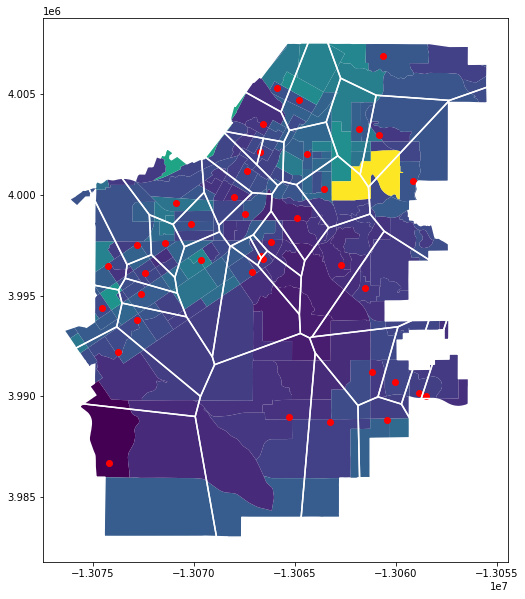

In [45]:
# overlay schools, RUSD repsiratory index and voronoi polygons
base = EJ_RUSD.plot(column='D_RESP_2')
schools_polygons.geometry.boundary.plot(ax=base, edgecolor='white') # these are the voronoi polygons
rusd_pts.plot(ax=base, color='red')

Estimate the EJ_respiratory hazards for a school using areal interpolation

In [46]:
#type(schools_polygons)

In [47]:
# schools_polygons.dtypes

In [48]:
RESP = tob.area_weighted.area_interpolate(source_df=EJ_RUSD,
                                           target_df=schools_polygons,
                                           intensive_variables=['D_RESP_2'])

In [49]:
RESP.head()

,D_RESP_2,geometry
0,20.450107,"MULTIPOLYGON (((-13057470.389 3993779.175, -13..."
1,-17.811262,"MULTIPOLYGON (((-13058738.935 3989890.951, -13..."
2,164.343134,"POLYGON ((-13072106.540 3997019.611, -13073314..."
3,-53.597176,"POLYGON ((-13065845.141 4000452.602, -13065598..."
4,46.859300,"POLYGON ((-13067444.923 4005075.853, -13065684..."


<AxesSubplot:>

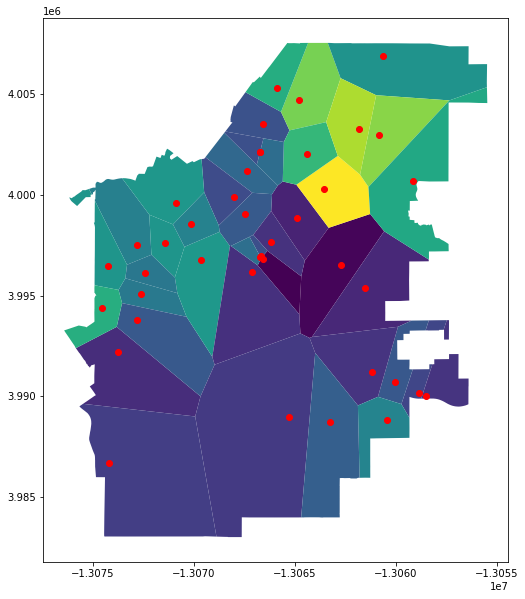

In [50]:
base = RESP.plot(column='D_RESP_2')
rusd_pts.plot(ax=base, color='red')

In [51]:
rusd_pts['D_RESP_2b'] = RESP.D_RESP_2
rusd_pts.head()

,gcs_mn_avg_ol,geometry,D_RESP_2a,D_RESP_2b
0,8.098470,POINT (-13058852.952 3990176.444),23.698113,20.450107
1,4.939048,POINT (-13058493.613 3990007.858),23.698113,-17.811262
2,3.253884,POINT (-13072820.209 3997488.544),261.324237,164.343134
3,3.960433,POINT (-13064910.068 3998854.898),-142.849901,-53.597176
4,3.599937,POINT (-13066553.478 4003513.021),-62.781118,46.859300


<AxesSubplot:xlabel='D_RESP_2a', ylabel='D_RESP_2b'>

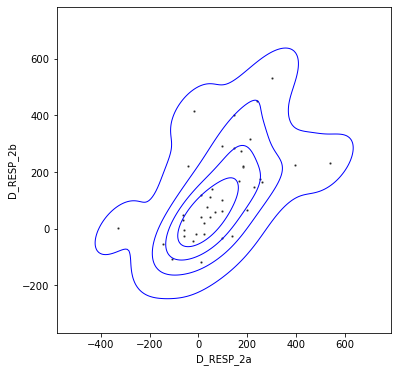

In [52]:
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 6))
x='D_RESP_2a'
y='D_RESP_2b'
sns.scatterplot(x=x, y=y, s=5, color=".15", data=rusd_pts)
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako", data=rusd_pts)
sns.kdeplot(x=x, y=y, levels=5, color="b", linewidths=1, data=rusd_pts)

#### Note: The two indices are positively correlated

In [53]:
# scatter plot for the two indices, D_RESP_2a is based on 1 to 1 relationship between schools and their location
# D_RESP_2b we obtained from voronoi interpolation
# sns.scatterplot(data=rusd_pts, x="D_RESP_2a", y="D_RESP_2b", alpha=0.5)

In [54]:
# subsetting the data set to contain the two indices
EJ_new= rusd_pts[['D_RESP_2a','D_RESP_2b']]


<AxesSubplot:>

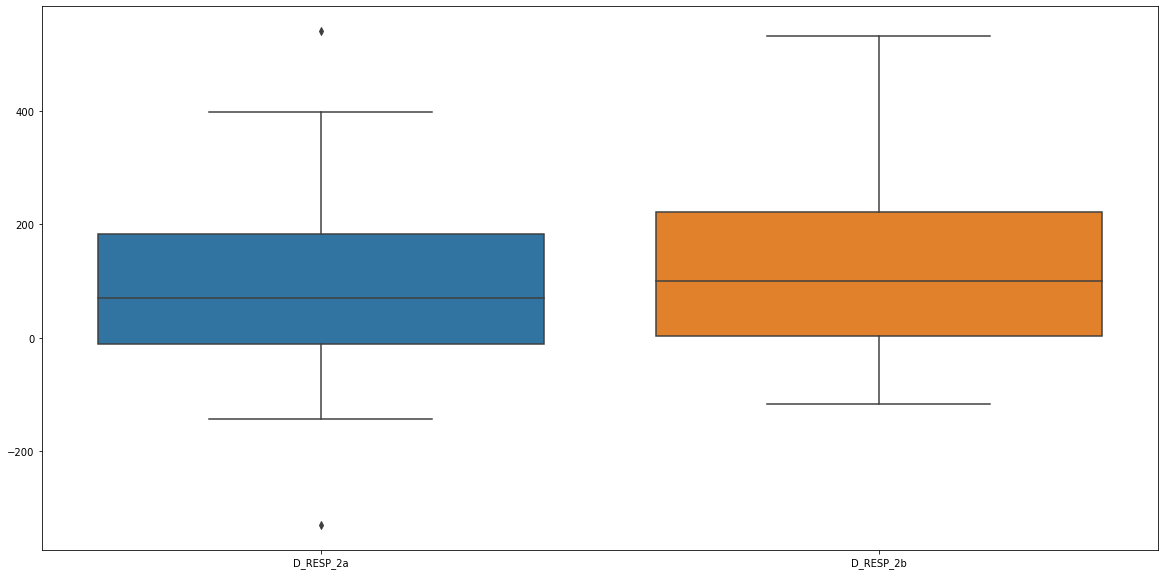

In [55]:
# the values of the two indices differ as seen by the boxplot
sns.boxplot(data=EJ_new)

#### 6. Checking Association between Schooling Outcome and EJ Respiratory Hazards Index

<AxesSubplot:xlabel='D_RESP_2b', ylabel='gcs_mn_avg_ol'>

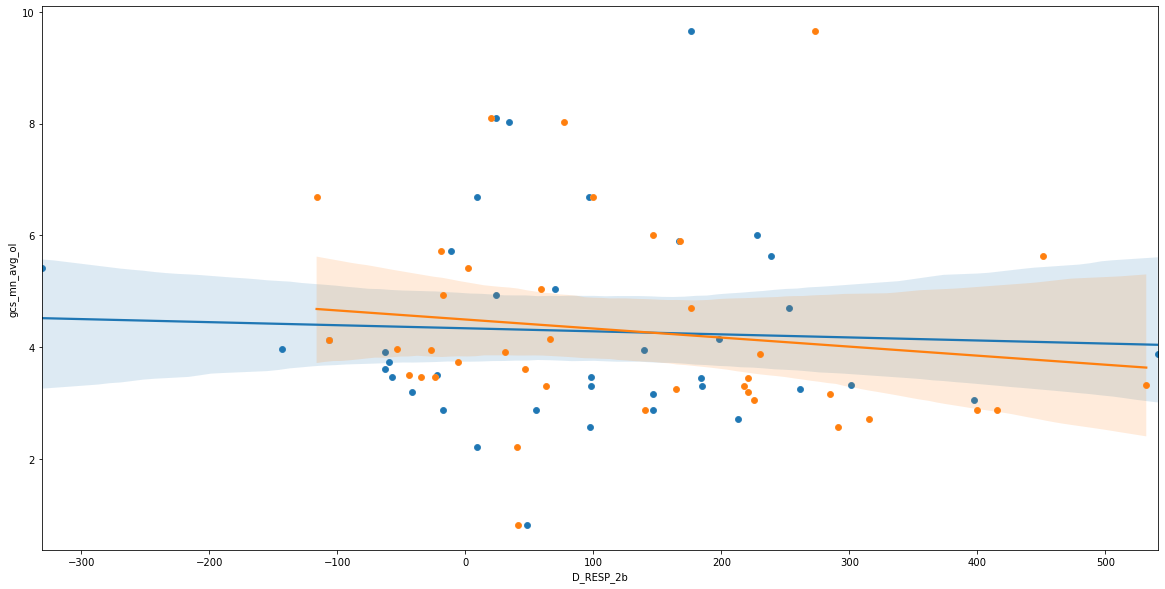

In [56]:
# mapping areal interpolation EJ respiratory Index
# Based on the 1 to 1 assocation - We are using the original EJ Repsiratory Hazards Index
sns.scatterplot(data=rusd_pts, x="D_RESP_2a", y="gcs_mn_avg_ol")
sns.regplot(data=rusd_pts, x='D_RESP_2a', y='gcs_mn_avg_ol')

# Based on the areal interpolation - We are using the new EJ Repsiratory Hazards Index
sns.scatterplot(data=rusd_pts, x="D_RESP_2b", y="gcs_mn_avg_ol")
sns.regplot(data=rusd_pts, x='D_RESP_2b', y='gcs_mn_avg_ol')


In [57]:
import statsmodels.api as sm 
import pandas
from patsy import dmatrices

vars = rusd_pts[['D_RESP_2a', 'D_RESP_2b', 'gcs_mn_avg_ol']]
vars.head()

,D_RESP_2a,D_RESP_2b,gcs_mn_avg_ol
0,23.698113,20.450107,8.098470
1,23.698113,-17.811262,4.939048
2,261.324237,164.343134,3.253884
3,-142.849901,-53.597176,3.960433
4,-62.781118,46.859300,3.599937


In [58]:
# Basic OLS Regression to Test for linear relationship between EJ index and School Performance
#y, X = dmatrices('gcs_mn_avg_ol ~ D_RESP_2a + D_RESP_2b', data=vars, return_type='dataframe')
#mod = sm.OLS(y, X) # create a model object
#res = mod.fit() # fit the model
#print(res.summary()) # Summarize the model

### Adding Racial Composition 

In [59]:
# Resetting the crs
rusd_racial = rusd_racial.to_crs("EPSG:3395")

<AxesSubplot:>

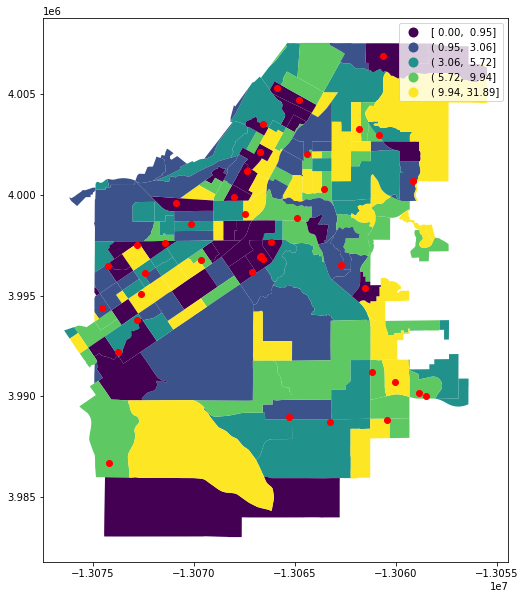

In [60]:
base = rusd_racial.plot(column='p_nonhisp_black_persons', scheme='Quantiles', k=5, legend=True)
rusd_pts.plot(ax=base, color='red')

<AxesSubplot:>

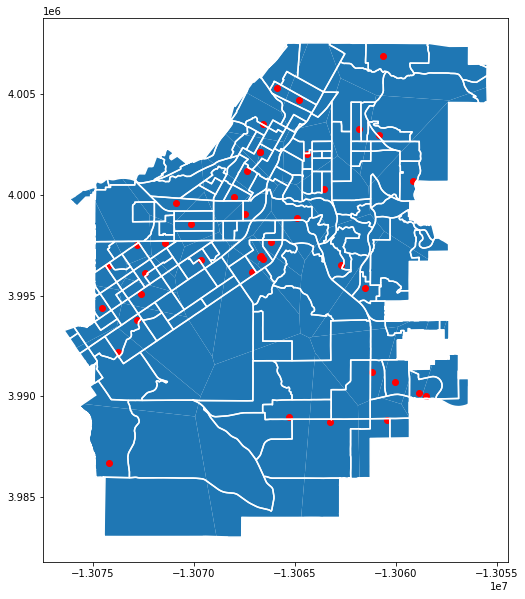

In [61]:
# White Race
base = rusd_racial.geometry.boundary.plot(edgecolor='white')
schools_polygons.plot(ax=base)
rusd_pts.plot(ax=base, color='red')

### Voronoi On Racial Composition

#### Approach 1 spatial join

In [62]:
# Checking for NAN values
rusd_racial.p_nonhisp_black_persons.unique

<bound method Series.unique of 0      12.791573
1       0.798935
2       0.744753
3       4.618250
4       0.000000
         ...    
169     4.131535
170     7.430489
171    14.453125
172    12.407992
173          NaN
Name: p_nonhisp_black_persons, Length: 174, dtype: float64>

In [63]:
p_nonhisp_black_persons =  rusd_racial.p_nonhisp_black_persons
rusd_racial.p_nonhisp_black_persons = p_nonhisp_black_persons.replace(to_replace= 'NaN', value=np.nan).astype(float)

In [64]:
p_nonhisp_white_persons =  rusd_racial.p_nonhisp_white_persons
rusd_racial.p_nonhisp_white_persons = p_nonhisp_white_persons.replace(to_replace= 'NaN', value=np.nan).astype(float)

In [65]:
racial_comp = gpd.sjoin(rusd_pts, rusd_racial, how='left', op='within')
racial_comp.head()

,gcs_mn_avg_ol,geometry,D_RESP_2a,D_RESP_2b,index_right,D_RESP_2,n_nonhisp_white_persons,n_nonhisp_black_persons,n_hispanic_persons,p_nonhisp_white_persons,p_nonhisp_black_persons,p_hispanic_persons,median_household_income
0,8.098470,POINT (-13058852.952 3990176.444),23.698113,20.450107,135,23.698113,1137.0,147.0,795.0,47.893850,6.192081,33.487784,88750.0
1,4.939048,POINT (-13058493.613 3990007.858),23.698113,-17.811262,135,23.698113,1137.0,147.0,795.0,47.893850,6.192081,33.487784,88750.0
2,3.253884,POINT (-13072820.209 3997488.544),261.324237,164.343134,85,261.324237,722.0,471.0,876.0,34.561991,22.546673,41.933940,31103.0
3,3.960433,POINT (-13064910.068 3998854.898),-142.849901,-53.597176,36,-142.849901,1115.0,104.0,323.0,68.573186,6.396064,19.864699,128750.0
4,3.599937,POINT (-13066553.478 4003513.021),-62.781118,46.859300,6,-62.781118,786.0,51.0,182.0,65.939597,4.278523,15.268456,85074.0


In [66]:
# percentage nohispanic blacks
schools_polygons['racial_comp'] = racial_comp.p_nonhisp_black_persons
rusd_pts['racial_comp'] = racial_comp.p_nonhisp_black_persons

<AxesSubplot:>

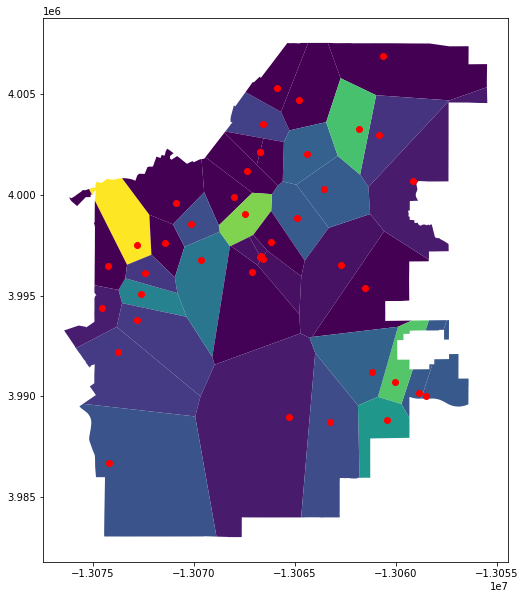

In [67]:
base = schools_polygons.plot(column='racial_comp')
rusd_pts.plot(ax=base, color='red')

#### Approach 2 areal interpolation

In [68]:
results = tob.area_weighted.area_interpolate(source_df=rusd_racial,
                                           target_df=schools_polygons,
                                           intensive_variables=['p_nonhisp_white_persons', 'p_nonhisp_black_persons','p_hispanic_persons'],
                                             extensive_variables=['n_nonhisp_white_persons','n_nonhisp_black_persons','n_hispanic_persons'])

/opt/tljh/user/lib/python3.7/site-packages/tobler/util/util.py:32: UserWarning: nan values in variable: p_nonhisp_white_persons, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/opt/tljh/user/lib/python3.7/site-packages/tobler/util/util.py:32: UserWarning: nan values in variable: p_nonhisp_black_persons, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/opt/tljh/user/lib/python3.7/site-packages/tobler/util/util.py:32: UserWarning: nan values in variable: p_hispanic_persons, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")


In [69]:
results.head()

,n_nonhisp_white_persons,n_nonhisp_black_persons,n_hispanic_persons,p_nonhisp_white_persons,p_nonhisp_black_persons,p_hispanic_persons,geometry
0,1491.876948,233.925630,1226.302781,45.008824,6.696854,35.100127,"MULTIPOLYGON (((-13057470.389 3993779.175, -13..."
1,3438.272861,334.779539,1927.795874,50.227170,4.602989,25.907859,"MULTIPOLYGON (((-13058738.935 3989890.951, -13..."
2,2372.561310,555.896215,5138.214893,28.414684,4.361397,63.169798,"POLYGON ((-13072106.540 3997019.611, -13073314..."
3,2438.975502,379.253611,2099.236901,55.778995,6.502012,31.933442,"POLYGON ((-13065845.141 4000452.602, -13065598..."
4,1779.746417,234.543730,2500.044873,53.742916,5.175762,31.511106,"POLYGON ((-13067444.923 4005075.853, -13065684..."


In [70]:
racial_comp['pctblack'] = results.n_nonhisp_black_persons / (results.n_nonhisp_black_persons + results.n_nonhisp_white_persons + results.n_hispanic_persons) * 100

In [71]:
racial_comp['pctwhite'] = results.n_nonhisp_white_persons / (results.n_nonhisp_black_persons + results.n_nonhisp_white_persons + results.n_hispanic_persons) * 100

In [72]:
racial_comp['pcthispanic'] = results.n_hispanic_persons / (results.n_nonhisp_black_persons + results.n_nonhisp_white_persons + results.n_hispanic_persons) * 100

In [73]:
racial_comp[['p_nonhisp_black_persons','pctblack','p_nonhisp_white_persons','pctwhite','p_hispanic_persons','pcthispanic']].head()

,p_nonhisp_black_persons,pctblack,p_nonhisp_white_persons,pctwhite,p_hispanic_persons,pcthispanic
0,6.192081,7.924027,47.893850,50.536033,33.487784,41.539940
1,6.192081,5.872451,47.893850,60.311601,33.487784,33.815948
2,22.546673,6.891270,34.561991,29.411896,41.933940,63.696833
3,6.396064,7.712379,68.573186,49.598218,19.864699,42.689403
4,4.278523,5.195532,65.939597,39.424332,15.268456,55.380136


<AxesSubplot:>

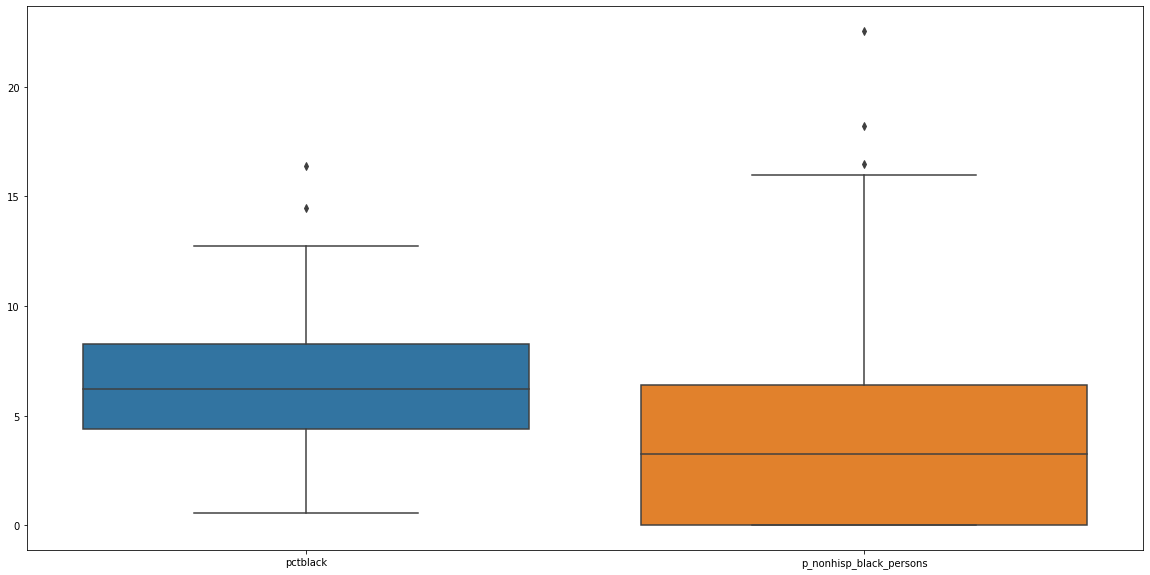

In [74]:
Racial_new= racial_comp[['pctblack','p_nonhisp_black_persons']]
sns.boxplot(data=Racial_new)

<AxesSubplot:xlabel='pctblack', ylabel='gcs_mn_avg_ol'>

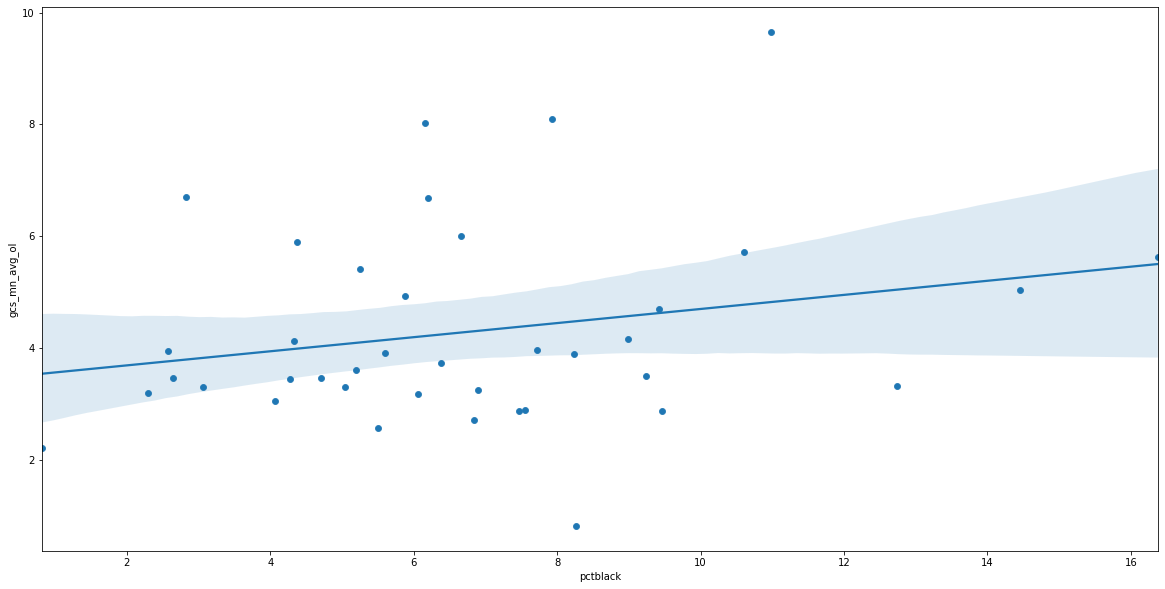

In [75]:
sns.scatterplot(data=racial_comp, x="pctblack", y="gcs_mn_avg_ol")
sns.regplot(data=racial_comp, x='pctblack', y='gcs_mn_avg_ol')

<AxesSubplot:xlabel='pcthispanic', ylabel='gcs_mn_avg_ol'>

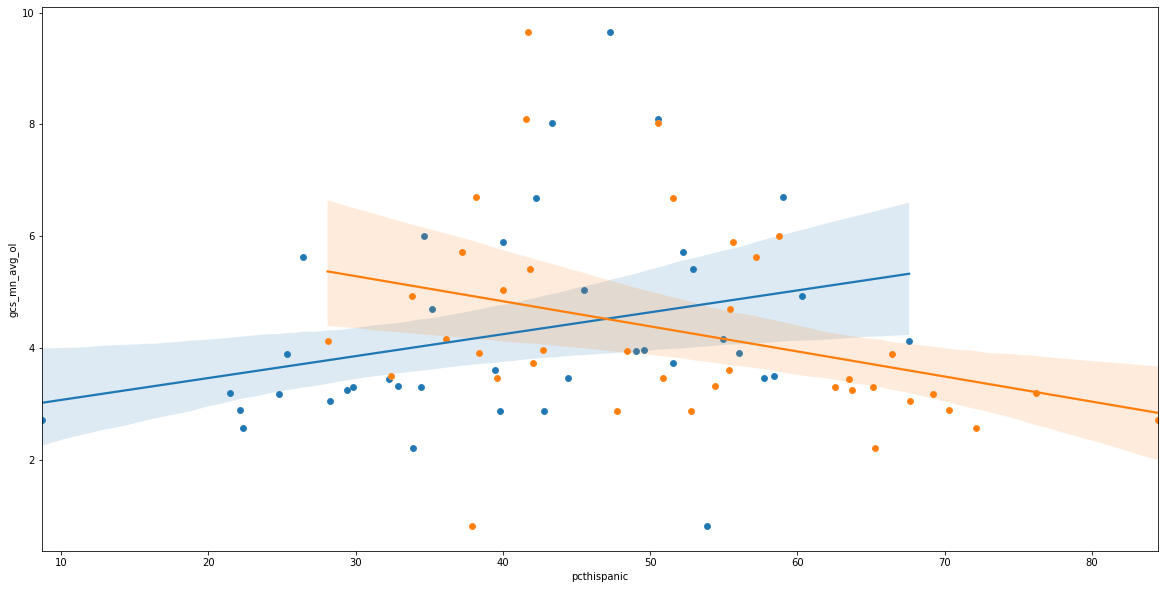

In [76]:
sns.scatterplot(data=racial_comp, x="pctwhite", y="gcs_mn_avg_ol")
sns.regplot(data=racial_comp, x='pctwhite', y='gcs_mn_avg_ol')
sns.scatterplot(data=racial_comp, x="pcthispanic", y="gcs_mn_avg_ol")
sns.regplot(data=racial_comp, x='pcthispanic', y='gcs_mn_avg_ol')

In [77]:
# Checking for Not a number (NAN)
racial_comp.median_household_income.unique

<bound method Series.unique of 0      88750.0
1      88750.0
2      31103.0
3     128750.0
4      85074.0
5     112321.0
6      83317.0
7          NaN
8      51389.0
9      50341.0
10    107727.0
11     82926.0
12     82926.0
13     60215.0
14     81250.0
15     70066.0
16     83320.0
17     60417.0
18     47708.0
19     38068.0
20    107321.0
21     65924.0
22     59286.0
23     45547.0
24     28403.0
25     41852.0
26     90320.0
27     65515.0
28     80991.0
29    107727.0
30    162800.0
31    107727.0
32    130027.0
33    104130.0
34    120114.0
35     83421.0
36     50341.0
37    116833.0
38     47917.0
39         NaN
40         NaN
Name: median_household_income, dtype: float64>

In [78]:
racial_comp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 41 entries, 0 to 40
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   gcs_mn_avg_ol            39 non-null     float64 
 1   geometry                 41 non-null     geometry
 2   D_RESP_2a                41 non-null     float64 
 3   D_RESP_2b                41 non-null     float64 
 4   index_right              41 non-null     int64   
 5   D_RESP_2                 41 non-null     float64 
 6   n_nonhisp_white_persons  41 non-null     float64 
 7   n_nonhisp_black_persons  41 non-null     float64 
 8   n_hispanic_persons       41 non-null     float64 
 9   p_nonhisp_white_persons  41 non-null     float64 
 10  p_nonhisp_black_persons  41 non-null     float64 
 11  p_hispanic_persons       41 non-null     float64 
 12  median_household_income  38 non-null     float64 
 13  pctblack                 41 non-null     float64 
 14  pctw

In [80]:
new_results = tob.area_weighted.area_interpolate(source_df=rusd_racial,
                                           target_df=schools_polygons,
                                           intensive_variables=['median_household_income'])

/opt/tljh/user/lib/python3.7/site-packages/tobler/util/util.py:32: UserWarning: nan values in variable: median_household_income, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")


In [81]:
new_results.head()

,median_household_income,geometry
0,95568.974895,"MULTIPOLYGON (((-13057470.389 3993779.175, -13..."
1,101555.142628,"MULTIPOLYGON (((-13058738.935 3989890.951, -13..."
2,61781.853625,"POLYGON ((-13072106.540 3997019.611, -13073314..."
3,114078.263800,"POLYGON ((-13065845.141 4000452.602, -13065598..."
4,68865.916433,"POLYGON ((-13067444.923 4005075.853, -13065684..."


In [82]:
racial_comp['income'] = new_results.median_household_income

In [83]:
racial_comp.head()

,gcs_mn_avg_ol,geometry,D_RESP_2a,D_RESP_2b,index_right,D_RESP_2,n_nonhisp_white_persons,n_nonhisp_black_persons,n_hispanic_persons,p_nonhisp_white_persons,p_nonhisp_black_persons,p_hispanic_persons,median_household_income,pctblack,pctwhite,pcthispanic,income
0,8.098470,POINT (-13058852.952 3990176.444),23.698113,20.450107,135,23.698113,1137.0,147.0,795.0,47.893850,6.192081,33.487784,88750.0,7.924027,50.536033,41.539940,95568.974895
1,4.939048,POINT (-13058493.613 3990007.858),23.698113,-17.811262,135,23.698113,1137.0,147.0,795.0,47.893850,6.192081,33.487784,88750.0,5.872451,60.311601,33.815948,101555.142628
2,3.253884,POINT (-13072820.209 3997488.544),261.324237,164.343134,85,261.324237,722.0,471.0,876.0,34.561991,22.546673,41.933940,31103.0,6.891270,29.411896,63.696833,61781.853625
3,3.960433,POINT (-13064910.068 3998854.898),-142.849901,-53.597176,36,-142.849901,1115.0,104.0,323.0,68.573186,6.396064,19.864699,128750.0,7.712379,49.598218,42.689403,114078.263800
4,3.599937,POINT (-13066553.478 4003513.021),-62.781118,46.859300,6,-62.781118,786.0,51.0,182.0,65.939597,4.278523,15.268456,85074.0,5.195532,39.424332,55.380136,68865.916433


<AxesSubplot:>

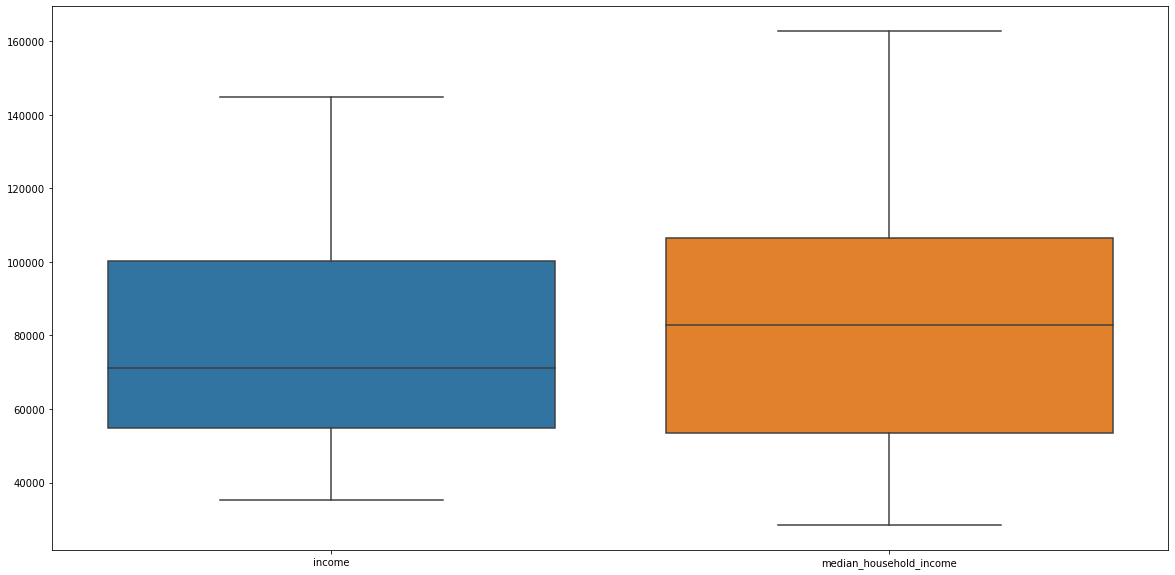

In [86]:
income_new= racial_comp[['income','median_household_income']]
sns.boxplot(data=income_new)

<AxesSubplot:xlabel='income', ylabel='gcs_mn_avg_ol'>

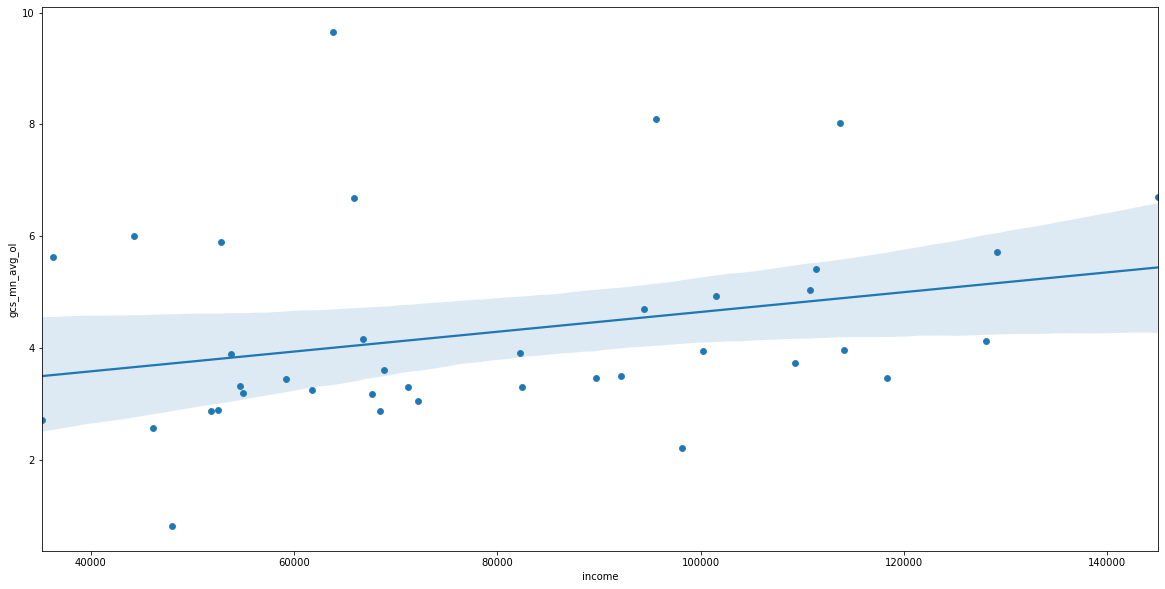

In [88]:
sns.scatterplot(data=racial_comp, x="income", y="gcs_mn_avg_ol")
sns.regplot(data=racial_comp, x='income', y='gcs_mn_avg_ol')